# Kalman filtering
> I have wanted to understand the Kalman filter for a long time. It is supposed to be very good to filter measurements from a dynamic system as a ship. Here are my notes about basic Kalman filtering.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [dynamics, kalman filter]
- image: images/kalman.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

I found an example from the [scipy-cookbook](https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html), which was taken from [An Introduction to the Kalman Filter](https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf). I will implement the same thing here, by dissecting the example from the [scipy-cookbook](https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html).

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

In [2]:
#collapse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

## scipy-cookbook
Here is the implementation from the [scipy-cookbook](https://scipy-cookbook.readthedocs.io/items/KalmanFiltering.html):

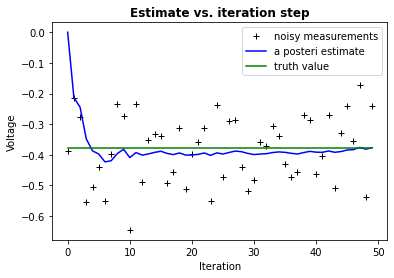

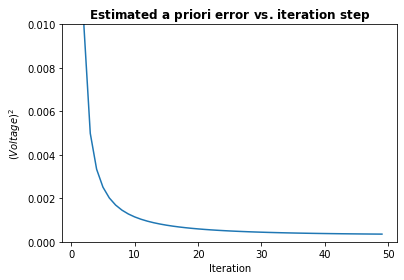

In [3]:
#collapse
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

# by Andrew D. Straw

# intial parameters
n_iter = 50
sz = (n_iter,) # size of array
x = -0.37727*np.ones(sz) # truth value (typo in example at top of p. 13 calls this z)
z = np.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=np.zeros(sz)      # a posteri estimate of x
P=np.zeros(sz)         # a posteri error estimate
xhatminus=np.zeros(sz) # a priori estimate of x
Pminus=np.zeros(sz)    # a priori error estimate
K=np.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q

    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

plt.figure()
plt.plot(z,'k+',label='noisy measurements')
plt.plot(xhat,'b-',label='a posteri estimate')
plt.plot(x,color='g',label='truth value')
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Voltage')

plt.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
plt.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('$(Voltage)^2$')
plt.setp(plt.gca(),'ylim',[0,.01]);

...so it seems that we want to filter some noisy measurements of voltage in this case.

## My rough idea about Kalman filter
From what I have seen of the Kalman filter before my rough understanding is this: you think that you have some kind of understanding of the system that you are measuring, why not use this as a part of the filtering? 

Consider the measurement of the position of a large ship: let's say the there is a "spike" in this signal. Lets also say that this spike has acceleration that would need an enormous force to be generated (considering the large mass of the ship). This enormous force is extremely unlikely and can be disregarding. So using your knowledge about the dynamics of the system you are observing to do filtering makes a lot of sense. 

I usually use low pass filtering of the model test measurements however, this filter does not "know" so much about the system that generated the signal. The only knowledge you add to a low pass filter is that you say that frequencies above a certain treshold cannot have been generated by the system you are interested in and should therefore be removed.

In the Kalman filter you add much more information about the system by adding a simulation model of the system that tries to predict the signal. The simulation model prediction and measurements "live" side by side. Both the prediction and measurement may contain errors (model errors or measurements errors) so the Kalman filter algorithm merges these two and the algorithm decide how much to trust the prediction or measurements based on how well they perform.


## Notes from: [An Introduction to the Kalman Filter](https://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf)
The process to be estimated should be expressed as a linear stochastic difference equation:
$$x_{k}=A x_{k-1}+B u_{k-1}+w_{k-1}$$
Mesurement:
$$z_{k}=H x_{k}+v_{k}$$

The "hat" means estimate: ${\hat{x}_{k}}$

The "minus" means "a priori" (which means "from earlier)": ${\hat{x}_{k}}^-$

Please not that ${\hat{x}_{k}}^-$ and ${\hat{x}_{k-1}}$ is not necessarily the same thing.

"a posteriori" means "from the later", so I guess this is about the future!? You would guess that that "a posteriori" would be denoted with a "pluss" but it does not so: ${\hat{x}_{k}}$ is the "a posteriori" estimate of ${x}_{k}$.

The "a priori" estimate error can be written:
$$e_{k}^{-} \equiv x_{k}-{\hat{x}_{k}}^-$$ 
where $x_{k}$ is the actual true value (this is neither the estimated ${\hat{x}_{k}}$ or the measurement $z_{k}$.)  

The "a posteriori" estimate error can be written:
$$e_{k} \equiv x_{k}-\hat{x}_{k}$$

The "a posteriori" estimate is calculated as:
$$\hat{x}_{k}=\hat{x}_{k}^-+K\left(z_{k}-H \hat{x}_{k}^-\right)$$
where $K$ is the *gain* or *blending factor*.

$$\begin{aligned}
K_{k} &=P_{k}^{-} H^{T}\left(H P_{k}^{-} H^{T}+R\right)^{-1} \\
&=\frac{P_{k}^{-} H^{T}}{H P_{k}^{-} H^{T}+R}
\end{aligned}$$
where $P_{k}^{-}$ is the a priori estimate error covariance:
$$P_{k}^{-}=E\left[e_{k}^{-} e_{k}^{-T}\right]$$

These equations are then used in the following itteration:
![](my_icons/kalman_process.PNG)


## Dissecting the volt example:
### Time update ("Predict"):
#### (1) Project the state ahead
The estimation model is proposed as simple as:
$$\begin{aligned}
x_{k} &=A x_{k-1}+B u_{k-1}+w_{k} \\
&=x_{k-1}+w_{k}
\end{aligned}$$
#### (2) Project the error covariance ahead
Since $A=1$:
$$P_{k}^{-}=P_{k-1}+Q$$

### Measurement Update ("Correct"):
#### (1) Compute the Kalman gain
$H$ is also $1$ so:
$$\begin{aligned}
K_{k} &=P_{k}\left(P_{k}^{-}+R\right)^{-1} \\
&=\frac{P_{k}^{-}}{P_{k}^{-}+R}
\end{aligned}$$
#### (2) Update estimate with measurement $z_k$
#### (3) Update the error covariance


So here is my reimplementation of the above example. I decided to split into submethods and I droped the "k" in the variable names, since it is always the "k:th-iteration" in these submethods. I also implemented the Kalman filter as abstract class that should be subclassed to define the estimation model for the particular system.

In [4]:
from abc import ABC, abstractmethod

class KalmanFilter(ABC):

    @abstractmethod
    def estimate_state(x_minus):       
        A = np.array([[1,0],[0,1]])
        x_minus=A.dot(x_)
        return
    
    @staticmethod
    def compute_kalman_gain(P_minus,R):
        """
        P_minus : error covariance ahead
        R : estimate of measurement variance
        """
        K=P_minus/(P_minus+R)
        return K
    
    @staticmethod
    def update_estimate(x_minus, K, z):
        x_hat_minus = x_minus + K*(z-H*x_minus)
        return x_hat_minus
    
    @staticmethod
    def update_error_coviariance(K, H, P_minus):
        I=np.eye(*H.shape) # 1 in this case
        P = (I-K*H)*P_minus
        return P
    
    def time_update(self, x_minus,P, Q):
        #### (1) Project the state ahead:
        x_hat_minus = self.estimate_state(x_minus)
        
        #### (2) Project the error covariance ahead:
        P_minus = P + Q
        
        return x_hat_minus,P_minus
    
    def measurement_update(self, P_minus, x_hat_minus, z, R, H):
        #### (1) Compute the Kalman gain:
        K=self.compute_kalman_gain(P_minus=P_minus, R=R)
        
        #### (2) Update estimate with measurement $z_k$
        x_hat = self.update_estimate(x_minus=x_hat_minus, K=K, z=z)
        
        #### (3) Update the error covariance
        P=self.update_error_coviariance(K=K, H=H, P_minus=P_minus)
        
        return K, x_hat, P
    
    def filter(self, z, x_hat_0, P_0, R, Q, H):
        """
        Filter signal z using Kalman filter
        
        Parameters
        ----------
        z : array_like
            raw signal
        x_hat_0 : float
            inital state guess
        P_0 : float 
            initial estimator error covariance guess
        R : float
            estimate of measurement variance
        Q : float
            process variance
        H : matrix_like
            H is the Jacobian matrix of partial derivatives of with respect to x???
        
        Returns
        -------
        df : pandas dataframe
            contain values for all itteration steps.
        
        """
        
        # intial guesses
        x_minus=x_hat_0
        P=P_0
        
        df = pd.DataFrame()
        for k in range(1,len(z)):
            # time update
            x_hat_minus, P_minus = self.time_update(x_minus=x_minus, P=P, Q=Q)    
        
            # measurement update
            K, x_minus, P = self.measurement_update(P_minus=P_minus, x_hat_minus=x_hat_minus, z=z[k], R=R, H=H)
            
            # save stuff:
            result = pd.Series(name=k)
            for i,x_ in enumerate(x_hat_minus):
                result['x_hat_minus%i'%i]=float(x_)
            
            result['P_minus']=float(P_minus)
            result['K']=float(K)
            
            for i,x_ in enumerate(x_minus):
                result['x_hat%i'%i]=float(x_)
            
            result['P']=float(P)
            result['z']=z[k]
            df=df.append(result)
        
        self.df=df
        return df
    
    def check_is_filtered(self):
        if not hasattr(self,'df'):
            raise ValueError('You need to filter first')
    
    def plot_estimation(self, x=None):
        
        self.check_is_filtered()
        
        fig,ax=plt.subplots()
        self.df.plot(y=['z'], style='x', ax=ax)
        self.df.plot(y=['x_hat_minus0'], style=':', ax=ax)
        self.df.plot(y=['x_hat0'], style='-', ax=ax)
        
        if not x is None:
            ax.plot(x,color='g',label='truth value')
        
        ax.legend()
        ax.set_title('Estimate vs. iteration step', fontweight='bold')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Voltage');
        ax.grid(True)
        
    def plot_error(self):
        
        self.check_is_filtered()
        
        fig,ax=plt.subplots()
        self.df.iloc[1:].plot(y=['P','P_minus'], style='-', ax=ax);
        ax.set_title('Estimated a priori and posteriori error vs. iteration step', fontweight='bold')
        ax.grid(True)
        
    def plot_gain(self):
        
        self.check_is_filtered()
        
        fig,ax=plt.subplots()
        self.df.iloc[1:].plot(y=['K'], style='-', ax=ax);
        ax.set_title('Kalman gain or blending factor')
        ax.grid(True)

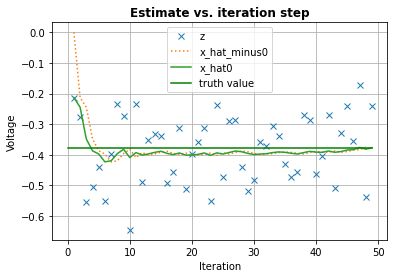

In [5]:
#collapse

class MyKalmanFilter(KalmanFilter):
    
    @staticmethod
    def estimate_state(x_minus):       
        return x_minus
    

H = np.array([1])

# intial guesses
x_hat_0 = [0.0]
P_0 = 1.0
kalman_filter = MyKalmanFilter()
df = kalman_filter.filter(z=z, x_hat_0=x_hat_0, P_0=P_0, R=R, Q=Q, H=H)
kalman_filter.plot_estimation(x=x)

The error decreses as the filter converges (when the estimation model gets better and better):

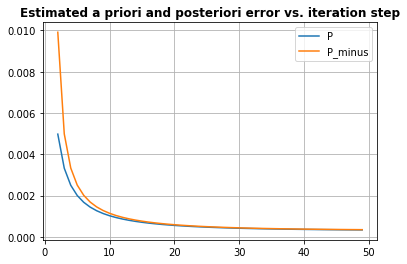

In [6]:
#collapse
kalman_filter.plot_error()


And as a consequence the Kalman gain $K$ decreases which means that the estimation uses less and less of the measurements $z_k$ and therefore rely more and more on the mathematical model: 
$$\hat{x}_{k}=\hat{x}_{k}^-+K\left(z_{k}-H \hat{x}_{k}^-\right)$$

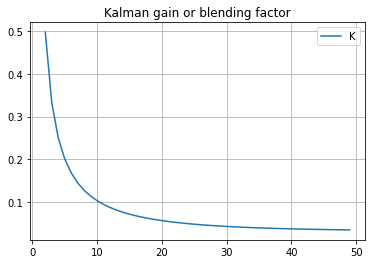

In [7]:
#collapse
kalman_filter.plot_gain()

Varying estimated measurement variance:

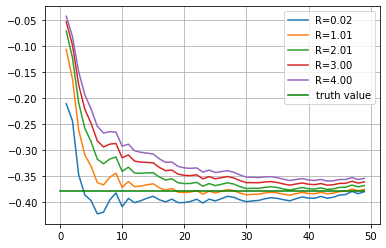

In [8]:
#collapse

Rs = np.linspace(0.01,2,5)*2

fig,ax=plt.subplots()
for R_ in Rs:
    df = kalman_filter.filter(z=z, x_hat_0=x_hat_0, P_0=P_0, R=R_, Q=Q, H=H)
    df.plot(y='x_hat0',ax=ax, label='R=%0.2f'%R_)
ax.plot(x,color='g',label='truth value')
ax.legend();
ax.grid(True)

Varying estimated process variance:

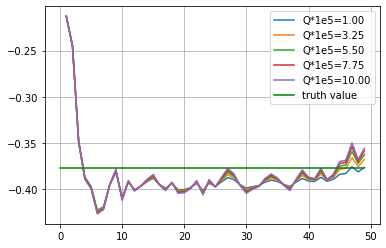

In [9]:
#collapse

Qs = np.linspace(1,10,5)*1e-5

fig,ax=plt.subplots()
for Q_ in Qs:
    df = kalman_filter.filter(z=z, x_hat_0=x_hat_0, P_0=P_0, R=R, Q=Q_, H=H)
    df.plot(y='x_hat0',ax=ax, label='Q*1e5=%0.2f'%(Q_*1e5))
ax.plot(x,color='g',label='truth value')
ax.legend();
ax.grid(True)

## Kalman filter for ball drop measurement
I will reuse the [Ball drop simulation](https://martinlarsalbert.github.io/blog/machine%20learning/regression/2019/12/14/01_spring_mass_damper.html#Ball-drop) to generate some measurements of a ball drop:

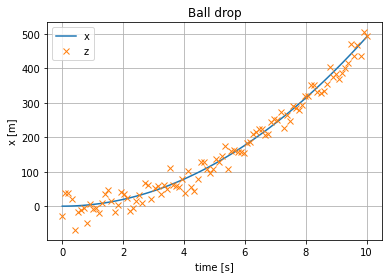

In [10]:
#collapse

g = 9.81
m = 1

def ball_drop(states,t):
    
    # states:
    # [x,v]
    # F = g*m = m*dv/dt
    # --> dv/dt = (g*m) / m
    
    x = states[0]
    dxdt = states[1]
    
    dvdt = (g*m) / m
    
    d_states_dt = np.array([dxdt,dvdt])
    
    return d_states_dt

states_0 = np.array([0,0])
N=100
t = np.linspace(0,10,N)
states = odeint(func = ball_drop,y0 = states_0,t = t)
x_ball = states[:,0]
dxdt_ball = states[:,1]

w = np.random.normal(0,20,size=N) # observations (normal about x, sigma=0.1)
z_ball = x_ball+w

fig,ax = plt.subplots()
ax.plot(t,x_ball,label = 'x')
ax.plot(t,z_ball,'x', label = 'z')


ax.set_title('Ball drop')
ax.set_xlabel('time [s]')
ax.set_ylabel('x [m]');
ax.legend();
ax.grid()

The solution is inspired by the example in [pykalman](https://pykalman.github.io/) package documentation.

In [11]:
class BallKalmanFilter(KalmanFilter):
    
    @staticmethod
    def estimate_state(x_minus):
        t=0.1
        A = np.array([[1, t, 0.5 * (t**2)],
              [0, 1,            t],
              [0, 0,            1]])
        
        x_minus=A.dot(x_minus)
        
        return x_minus
    

In [12]:
#collapse
ball_kalman_filter = BallKalmanFilter()

x_hat_0=np.array([[0],[0],[-9.8]])


df_ball = ball_kalman_filter.filter(z=z_ball, x_hat_0=x_hat_0, P_0=1, R=10, Q=1, H=np.array([1,1,1]))
ball_kalman_filter.plot_estimation(x=x_ball)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
#collapse
ball_kalman_filter.plot_error()

In [ ]:
#collapse
ball_kalman_filter.plot_gain()